# Impedance, admittance and scattering analysis
### Prerequisite
You need to have a working local installation of Ansys.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

## 1. Create the design in Metal
Set up a design of a given dimension. Dimensions will be respected in the design rendering. <br>
Note that the design will be centered in the origin, will thus equally extend in all quadrants.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

Create a single transmon with one readout resonator. It will show in the center of the previously defined chip.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options =  dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))

gui.rebuild()
gui.autoscale()

## 2. Eigenmode and Impedance analysis using the analysis package - most users

#### Setup

Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation.

In [4]:
from qiskit_metal.analyses.quantization import ScatteringImpedanceSim
em1 = ScatteringImpedanceSim(design, "hfss")

Review and update the setup. For driven modal you will need to define not only the simulation convergence parameters, but also the frequency sweep.

Customizable parameters and default values:
* freq_ghz=5 (simulation frequency)
* name="Setup" (setup name)
* max_delta_s=0.1 (absolute value of maximum difference in scattering parameter S)
* max_passes=10 (maximum number of passes)
* min_passes=1 (minimum number of passes)
* min_converged=1 (minimum number of converged passes)
* pct_refinement=30 (percent refinement)
* basis_order=1 (basis order)
* vars (global variables to set in the renderer)
* sweep_setup (all the parameters of the sweep)
 * name="Sweep" (name of sweep)
 * start_ghz=2.0 (starting frequency)
 * stop_ghz=8.0 (stopping frequency)
 * count=101 (total number of frequencies)
 * step_ghz=None (frequency step size)
 * type="Fast" (type of sweep)
 * save_fields=False (whether or not to save fields)
 
The following two cells will give you an example on how to update the setup.

In [5]:
em1.setup.sim

{'name': 'Setup',
 'reuse_selected_design': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [6]:
# example: update single setting
em1.setup.sim.max_passes = 12
em1.setup.sim.sweep_setup.stop_ghz = 13
# example: update multiple settings
em1.setup_update("sim", max_delta_s = 0.15, freq_ghz = 5.2)

em1.setup.sim

{'name': 'Setup',
 'reuse_selected_design': True,
 'freq_ghz': 5.2,
 'max_delta_s': 0.15,
 'max_passes': 12,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 13,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

#### Execute simulation and observe the Impedence
Analyze a single qubit with shorted terminations. Assign lumped ports on the readout and on the junction. Then observe the impedance plots.

Here, pin Q1_a is converted into a lumped port with an impedance of 70 Ohms. <br>
Meanwhile, the central junction Q1_rect_jj is rendered as both a port and an inductor with an impedance of 50 Ohms and an inductance of 10 nH, respectively.

The 10nH inductance value is taken from the component option `hfss_inductance` (And the component options find their way in the QGeometry tables by rebuilding). So let's demonstrate how to update the inductance of the junction in the next cell.

In [7]:
q1.options.hfss_inductance='11nH'
gui.rebuild()

Now we can run the simulation with the newly set `11 nH` value.

In [8]:
em1.run(name="SingleTM", components=[], open_terminations=[], port_list=[('Q1', 'readout', 70)],
           jj_to_port=[('Q1', 'rect_jj', 50, True)], box_plus_buffer = False)

INFO 03:14PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:14PM [load_ansys_project]: 	Opened Ansys App
INFO 03:14PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:14PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project20
INFO 03:14PM [connect_design]: No active design found (or error getting active design).
INFO 03:14PM [connect]: 	 Connected to project "Project20". No design detected
INFO 03:14PM [connect_design]: 	Opened active design
	Design:    SingleTM_hfss [Solution type: DrivenModal]
WARNING 03:14PM [connect_setup]: 	No design setup detected.
WARNING 03:14PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 03:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:14PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:14PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:14PM [analyze]: Analyzing setup Setup1 : 

The last variables you pass to the `run()` or `run_sim()` methods, will be stored in the `setup` dictionary under the key `run`. You can recall the information passed by either accessing the dictionary directly, or by using the print handle below.

In [9]:
# em1.setup.run    <- direct access
em1.print_run_args()

This analysis object run with the following kwargs:
{'name': 'SingleTM', 'components': [], 'open_terminations': [], 'port_list': [('Q1', 'readout', 70)], 'jj_to_port': [('Q1', 'rect_jj', 50, True)], 'ignored_jjs': None, 'box_plus_buffer': False}



(optional) Captures the renderer GUI.

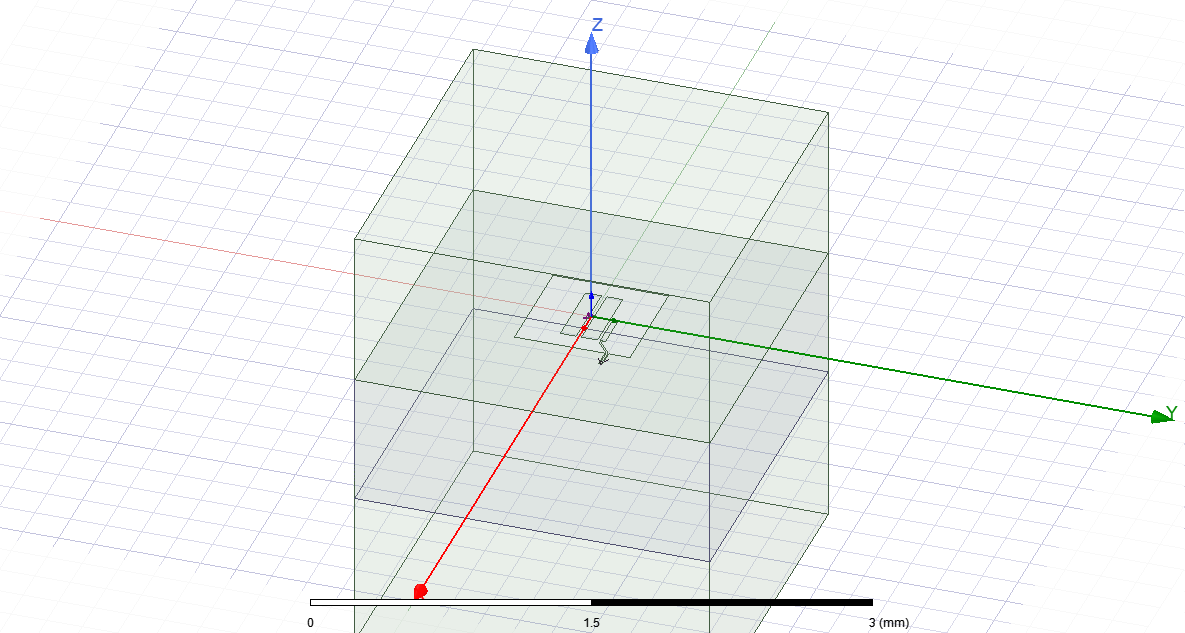

In [10]:
em1.save_screenshot()

(optional) if you ever feel the need to remind yourself which project, design, and setup is currently active (connected to qiskit-metal) you can use the following lines.

In [11]:
print(f"""
project_name = {em1.renderer.pinfo.project_name}
design_name  = {em1.renderer.pinfo.design_name}
setup_name   = {em1.renderer.pinfo.setup_name}
""")


project_name = Project20
design_name  = SingleTM_hfss
setup_name   = Setup1



Finally, you can plot the various parameters. The semicolon at the end of the cell can be used to suppress the inline return.

In [12]:
em1.get_impedance();  # default: ['Z11', 'Z21']

In [13]:
em1.get_admittance();  # default: ['Y11', 'Y21']

In [14]:
em1.get_scattering();  # default: ['S11', 'S21', 'S22']

Finally, disconnect from Ansys.

In [15]:
em1.close()

## 3. Directly access the renderer to modify other parameters

In [16]:
em1.start()
em1.renderer

INFO 03:15PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:15PM [load_ansys_project]: 	Opened Ansys App
INFO 03:15PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:15PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project20
INFO 03:15PM [connect_design]: 	Opened active design
	Design:    SingleTM_hfss [Solution type: DrivenModal]
INFO 03:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:15PM [connect]: 	Connected to project "Project20" and design "SingleTM_hfss" 😀 



Every renderer will have its own collection of methods. Below an example with hfss.

##### Prepare and run a collection of predefined setups

This is equivalent to going to the Project Manager panel in Ansys, right clicking on Analysis within the active HFSS design, selecting "Add Solution Setup...", and choosing/entering default values in the resulting popup window. You might want to do this to keep track of different solution setups, giving each of them a different/specific name.

In [17]:
setup = em1.renderer.new_ansys_setup(name = "Setup_demo", max_passes = 6)

You can directly pass to `new_ansys_setup` all the setup parameters. Of course you will then need to run the individual setups by name as well.

In [18]:
em1.renderer.analyze_setup(setup.name)

INFO 03:15PM [get_setup]: 	Opened setup `Setup_demo`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:15PM [analyze]: Analyzing setup Setup_demo


In [20]:
em1.close()